In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

%matplotlib inline

from scipy import interpolate
from mpl_toolkits.basemap import Basemap
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.misc import imread

In [79]:
def make_diagram(_year):
    '''
    do all of the stuff for the graphics of making a hurricane plot
    
    takes in the year dataframe in order to get the necessary data
    
    returns ax which is the figure axis that the current hurricane track will be added upon
    '''
        # establish the figure
    figure, axis = plt.subplots(figsize=(19.2,12.00), dpi=100)
    
    data = np.linspace(165.0, 0, 10000).reshape(100,100)
#     data = np.clip(randn(250, 250), -1, 1)

    histo_image = axis.imshow(data, interpolation='nearest', cmap="inferno")
    
    divider = make_axes_locatable(axis)
    
    cax = divider.append_axes("right", size="2%", pad=0.05)

    # Add colorbar, make sure to specify tick locations to match desired ticklabels
    cbar = figure.colorbar(histo_image, ticks=[157, 130, 111, 96, 74, 39, 0], cax=cax)
    cbar.ax.set_yticklabels(['5^', '4^', '3^', '2^', '1^', 'T.S.^', 'T.D.^'])  # vertically oriented colorbar
    
    axis.imshow(map_image, extent=[-120, -30, 0, 50],zorder=0)
    axis.set_title("North American Hurricane Tracks " + str(_year), size=20)
    axis.set_xlabel("Longitude", size=16)
    axis.set_ylabel("Latitude", size=16)
    axis.set_facecolor("black")
    axis.set_xlim(-120.0, -30.0)
    axis.set_ylim(0, 50.0)
    
    return figure, axis

def make_historical_diagram():
    '''
    do all of the stuff for the graphics of making a hurricane plot
    
    takes in the year dataframe in order to get the necessary data
    
    returns ax which is the figure axis that the current hurricane track will be added upon
    '''
    # establish the figure
    figure = plt.figure(figsize=(19.2, 12.0), dpi=100)
    
    axis = figure.add_subplot(111)
    axis.set_facecolor("#000000")
    
#     figure, axis = plt.subplots(figsize=(19.2,12.00), dpi=100)
    
#     data = np.linspace(165.0, 0, 10000).reshape(100,100)
# #     data = np.clip(randn(250, 250), -1, 1)

#     histo_image = axis.imshow(data, interpolation='nearest', cmap="inferno")
    
#     divider = make_axes_locatable(axis)
    
#     cax = divider.append_axes("right", size="2%", pad=0.05)

#     # Add colorbar, make sure to specify tick locations to match desired ticklabels
#     cbar = figure.colorbar(histo_image, ticks=[157, 130, 111, 96, 74, 39, 0], cax=cax)
#     cbar.ax.set_yticklabels(['5^', '4^', '3^', '2^', '1^', 'T.S.^', 'T.D.^'])  # vertically oriented colorbar
#     axis.set_title("North American Hurricane Tracks " + str(_year), size=20)
#     axis.set_xlabel("Longitude", size=16)
#     axis.set_ylabel("Latitude", size=16)
#     axis.set_facecolor("black")
    axis.set_xlim(-120.0, -30.0)
    axis.set_ylim(0, 50.0)
    
    return figure, axis

def plot_historical_storm(fig, ax, old_storm):
    '''
    returns axis that has had a historical storm scatter plot applied
    
    in long run make the rest of the scatter plot transparent so it can be additively added to historical stuff
    '''
    
    # get data for the plot
    old_length, old_lat, old_long, old_width, old_colors = transform_storm(old_storm, True)
    
    # if the storm track is too short the values above will equal 0, and no data is returned
    # in that case don't render the path but simply pass
    
    if old_length != 0:
        # actually make the plot
        ax.scatter(old_long, old_lat, alpha=1, s=old_width, c=old_colors, lw=0)
    else:
        pass
    
def plot_current_storm(fig, ax, storm, _slice=0):
    '''
    returns axis that has had a historical storm scatter plot applied
    
    in long run make the rest of the scatter plot transparent so it can be additively added to historical stuff
    '''
    
    # get data for the plot
    old_length, old_lat, old_long, old_width, old_colors = transform_storm(storm, False, _slice)
    
    # if the storm track is too short the values above will equal 0, and no data is returned
    # in that case don't render the path but simply pass
    
    if old_length != 0:
        # actually make the plot
        ax.scatter(old_long, old_lat, alpha=1, s=old_width, c=old_colors, lw=0)
    else:
        pass

def scale_lat(y, _height):
    '''
    Take a value from latitude range and modify it to screen position
    
    return the fixed value
    '''
    # top of picture is 0 and bottom of picture is _height?
    # ^ might have to reverse this but that is easy
    #
    #   ylim is 0 to 50 so for a few values of y:
    # y = 0    ypx = 1199
    # y = 25   ypx = ~600
    # y = 35   ypx = (50 - y)/50 * 1200 = ~360
    # y = 50   ypx = 0
    return int((y) / 50.0 * _height)
    
    
def scale_long(x, _width):
    '''
    Take a value from longitude range and modify it to screen position
    
    return the fixed value
    '''
    # left of picture should be 0, right side of picture should be 1920
    # ^ again might have reversed
    #
    # xlim is -120 to -30 so for a few values of x:
    # x = -120  xpx = 0
    # x = -75   xpx = ~960
    # x = -40
    # x = -30   xpx = 1920
    # 
    # initial range is -120 to -30
    #
    # x + 120 range becomes:
    # 0 to 90
    # then (x / 90.0) * 1920
    #
    # therefore xpx = ((x + 120) / 90.0) * 1920
    return ((x + 120) / 90.0) * 1920
    
def transform_storm(storm, historical=False, _slice=0):
    ##################################
    # get np columns for key data ####
    ##################################
    
    if len(storm) >= 10:
        interpolation_multiplier = 24
        
        _chop = _slice * interpolation_multiplier
        
        _lat = storm.Latitude.apply(lambda x: float(x))
        _long = storm.Longitude.apply(lambda x: float(x))
        
        if historical == False:
            _width = (storm.loc[:, "saffir_simpson_cat"] + 2)**1.3 * 100
        else:
            _width = (storm.loc[:, "saffir_simpson_cat"] + 2)**1.3 * 10
        _colors = storm.loc[:,"Wind(WMO)"].apply(lambda x: x / 165.0)

        x = np.arange(len(_lat))

        # Interpolate the data using a cubic spline to "new_length" samples
        # going from daily intervals to (interpolated) hourly
        if historical is False:
            new_length = interpolation_multiplier * len(_lat)
        else:
            new_length = interpolation_multiplier * len(_lat)

        # figure out length of new arrays
        new_x = np.linspace(x.min(), x.max(), new_length)

        # actually do the interpolation
        new_lat = interpolate.interp1d(x, _lat, kind='cubic')(new_x)
        new_long = interpolate.interp1d(x, _long, kind='cubic')(new_x)
        new_width = interpolate.interp1d(x, _width, kind='cubic')(new_x)
        new_colors = interpolate.interp1d(x, _colors, kind='cubic')(new_x)

        if historical is False:
            # convert colors from float to rgba using colormap
            new_colors = cm.inferno(new_colors)
        else:
            # try bone colors
            new_colors = cm.Greys_r(new_colors)
#             new_colors = cm.inferno(new_colors)

        # if slice is that the default value then return all of the data
        if _slice == 0:
            return new_length, new_lat, new_long, new_width, new_colors
        else:
            return new_length, new_lat[:_chop], new_long[:_chop], \
                new_width[:_chop], new_colors[:_chop]

    # the storm track is too short, return guardian values
    else:
        return 0, 0, 0, 0, 0

def safsimpsonize(wind):
    '''
    Takes in wind speed
    
    Returns saffir-simpson hurricane category with 0 and -1 for tropical storm/depression
    which doesn't make perfect sense as scales go but this maintains categories but allows
    the model/visualization to detect when something is a tropical depression
    
    According to: https://en.wikipedia.org/wiki/Saffir%E2%80%93Simpson_scale
    
    Return:  Category:   Wind Speed Range: (mph, seriously?)
    5        Cat 5      157 <= v
    4        Cat 4      130 <= v < 157
    3        Cat 3      111 <= v < 130
    2        Cat 2      96 <= v < 111
    1        Cat 1      74 <= v < 96
    0        Storm      39 <= v < 74
    -1       Depression v < 39
    '''
    if wind >= 157:
        return 5
    elif wind >= 130:
        return 4
    elif wind >= 111:
        return 3
    elif wind >= 96:
        return 2
    elif wind >= 74:
        return 1
    elif wind >= 39:
        return 0
    else:
        return -1

def load_hurricane_data(_path="../data/allstorms.csv"):
    data = pd.read_csv(_path)

    # data dictionary
    # N/A,Year,#,BB,BB,N/A,YYYY-MM-DD HH:MM:SS,N/A,deg_north,deg_east,kt,mb,N/A,%,%,N/A

    data.loc[:,"Season"] = data.loc[:,"Season"].apply(lambda x: int(x))

#     print data.loc[:,"Basin"].unique()
    # array(['BB', ' SI', ' NA', ' EP', ' SP', ' WP', ' NI', ' SA'], dtype=object)

    data.loc[:, "Basin"] = data.loc[:, "Basin"].apply(lambda x: x.replace(" ", ""))

#     print data.loc[:,"Basin"].unique()
    # ['BB' 'SI' 'NA' 'EP' 'SP' 'WP' 'NI' 'SA']

    data_na = data[data.loc[:, "Basin"] == "NA"]
    
    data_na.loc[:,"saffir_simpson_cat"] = data_na["Wind(WMO)"].apply(lambda x: safsimpsonize(x))

    # try to give back memory
    del data
    
    return data_na

def get_data_as_yearlist(start_year, end_year):
    '''
    take in data frame (north atlantic most likely) and turn it into a list of dataframes
    with each entry being a dataframe holding a year's data
    '''
    # load data frame that we want
    data_na = load_hurricane_data()
    
    # make a list for the years
    years = []

    # step through the Seasons (years) and make a new dataframe for each one
    for year in data_na.loc[:, "Season"].unique():
        temp = data_na[data_na.loc[:, "Season"] == year]
        years.append(temp)

    # get rid of a nan DataFrame
    years.pop(0)

    #loop through years in future gif
    start = 164 - (2016 - start_year)
    end = 164 - (2016 - end_year)
    
    if start != end:
        temp = years[start:end]
    else:
        # handle case where only one year is wanted
        temp = []
        temp.append(years[start])
    
    # try to give back memory
    del years
    
    return temp

def get_storms_from_year(year_df):
    '''
    year_df is the dataframe with a year's data
    
    returns a list of smaller dataframes each consisting of a 
    unique storm track
    '''
    storms = []
    
    # step through the year and make a dataframe for each storm
    for storm in year_df.loc[:,"Serial_Num"].unique():
        storms.append(year_df[year_df.loc[:, "Serial_Num"] == storm])
        
    return storms

Storms: 16
first max 406
total_layers: 16
max first: 255


KeyboardInterrupt: 

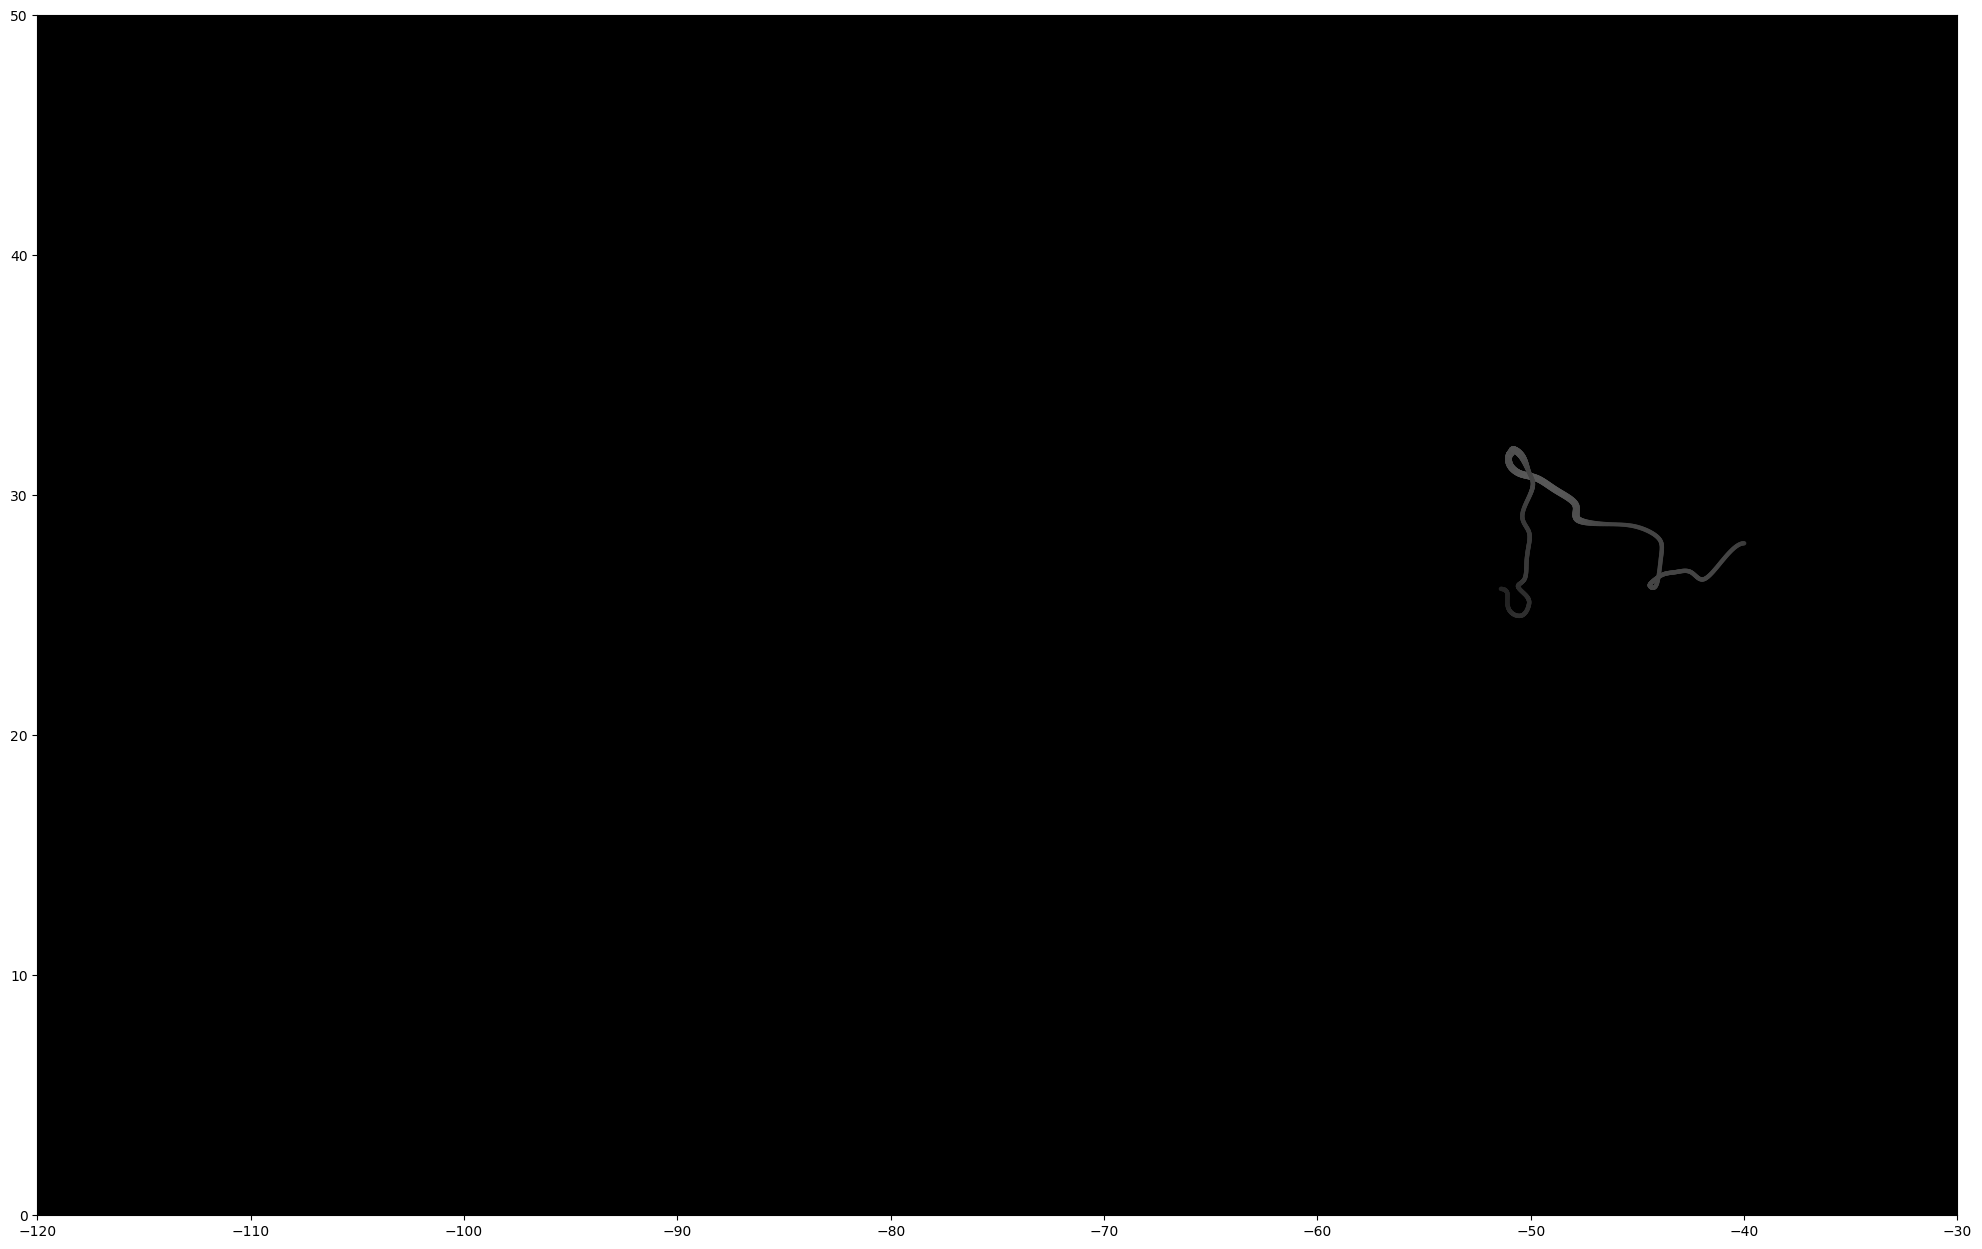

In [80]:
map_image = imread("../data/north_america_edited.png")

_start = 2004
_end = 2006

years = get_data_as_yearlist(_start, _end)

storms = []
# make a temp list to hold the storm dataframes from a single year
for _x, year in enumerate(years):
    fig, ax = make_historical_diagram()
    
    if _x > 0:
        break

    # additive code from:
    # http://samreay.github.io/blog/2016/10/01/additive.html
    fig.subplots_adjust(0, 0, 1, 1)

    # Draw the empty axis, which we use as a base.
    fig.canvas.draw()
    w, h = fig.canvas.get_width_height()
    _buffer = np.frombuffer(fig.canvas.buffer_rgba(), np.uint8)
    first = _buffer.astype(np.int16).reshape(h, w, -1) #int16 so we dont overflow
    first[first[:, :, -1] == 0] = 0 # Set transparent pixels to 0

    storms = get_storms_from_year(year)

    num_storms = len(storms)
    print "Storms:", num_storms

    total_layers = 0

    # figure out what the year is
    _year = year.loc[:, "Season"].unique()[0]

    _filename = "xplot_{}.png".format(_year)

    for storm in storms:
        total_layers += 1

        ax.clear()  # maybe clear erases some of the axis settings, not just the canvas?
        ax.set_xlim(-120.0, -30.0)
        ax.set_ylim(0, 50.0)
        ax.patch.set_facecolor('#000000')
        plot_historical_storm(fig, ax, storm)
        fig.canvas.draw()
        img = np.frombuffer(fig.canvas.buffer_rgba(), np.uint8).astype(np.int16).reshape(h, w, -1)
        img[img[:, :, -1] == 0] = 0
        first += img # Add these particles to the main layer

    heater = np.copy(first)
    
    _max = first[:,:,0].max()
    
    print "first max", _max
    

    first[:,:,0] = np.sqrt(first[:,:,0]) * (255.0 / np.sqrt(_max))
    first[:,:,1] = np.sqrt(first[:,:,1]) * (255.0 / np.sqrt(_max))
    first[:,:,2] = np.sqrt(first[:,:,2]) * (255.0 / np.sqrt(_max))
    print "total_layers:", total_layers

    print "max first:", first[:,:,0].max()

    # first = first / (total_layers * 1.0)**0.5

    first = np.clip(first, 0, 255) # clip buffer back into int8 range
                                    # wonder if some kind of exp transform
                                    # might enable hdr-like effect
    for a in range(first.shape[0]):
        for b in range(first.shape[1]):
            if first[a][b][0] == 0 and first[a][b][1] == 0 and first[a][b][2] == 0:
                first[a][b][3] = 0


    ax.clear()
    plt.axis("off")
    # ax.imshow(map_image, extent=[-120, -30, 0, 50])
    ax.imshow(first.astype(np.uint8), cmap="inferno", aspect='auto', alpha=1.0, extent=[-120, -30, 0, 50])
    fig.savefig("../imgs/test/{}".format(_filename), pad_inches=0, transparent=True)
    ax.clear()


In [59]:
len(heater)

1200

In [64]:
print heater.shape

print heater.max()

sub_heater = heater[:,:,3]

print sub_heater.shape

print sub_heater.max()

# x = sub_heater[:,:]

# fig, ax = make_historical_diagram()

# ax.clear()  # maybe clear erases some of the axis settings, not just the canvas?
# ax.set_xlim(-120.0, -30.0)
# ax.set_ylim(0, 50.0)
# ax.patch.set_facecolor('#000000')

# # ax.hexbin(x, y, gridsize=50, bins='log', cmap='inferno')
# ax.imshow(sub_heater, cmap="inferno")

(1200, 1920, 4)
3315
(1200, 1920)
3315


In [65]:
boink = sub_heater[0:100,0:100]

In [66]:
print list(boink)

[array([3315, 3315, 3315, 3315, 3315, 3315, 3315, 3315, 3315, 3315, 3315,
       3315, 3315, 3315, 3315, 3315, 3315, 3315, 3315, 3315, 3315, 3315,
       3315, 3315, 3315, 3315, 3315, 3315, 3315, 3315, 3315, 3315, 3315,
       3315, 3315, 3315, 3315, 3315, 3315, 3315, 3315, 3315, 3315, 3315,
       3315, 3315, 3315, 3315, 3315, 3315, 3315, 3315, 3315, 3315, 3315,
       3315, 3315, 3315, 3315, 3315, 3315, 3315, 3315, 3315, 3315, 3315,
       3315, 3315, 3315, 3315, 3315, 3315, 3315, 3315, 3315, 3315, 3315,
       3315, 3315, 3315, 3315, 3315, 3315, 3315, 3315, 3315, 3315, 3315,
       3315, 3315, 3315, 3315, 3315, 3315, 3315, 3315, 3315, 3315, 3315,
       3315], dtype=int16), array([3315, 3315, 3315, 3315, 3315, 3315, 3315, 3315, 3315, 3315, 3315,
       3315, 3315, 3315, 3315, 3315, 3315, 3315, 3315, 3315, 3315, 3315,
       3315, 3315, 3315, 3315, 3315, 3315, 3315, 3315, 3315, 3315, 3315,
       3315, 3315, 3315, 3315, 3315, 3315, 3315, 3315, 3315, 3315, 3315,
       3315, 3315, 331